# Blink preprocessing

One important step in the processing of pupillometric data is the handling of blinks.

In [3]:
import sys
sys.path.insert(0,"..") # this is not needed if you have installed pypillometry
import pypillometry as pp
import pylab as plt

## Blink detection

The first step is, of course, the identification of blinks. For this, we can use the `blinks_detect()` function:

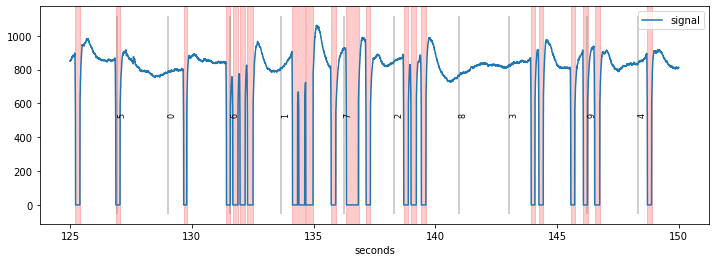

In [19]:
d=pp.PupilData.from_file("../data/example_shortblinks.pd")
plt.figure(figsize=(12,4))
d.blinks_detect().plot()

Detected blinks are marked in red in the plot. In the current case, the blink-detection did a reasonable job with the default settings but the `blinks_detect()` function has many parameters that can be tweaked.

The function `blinks_detect()` looks blinks using several strategies:

- First, blinks are detected as consecutive sequence of 0 (or another placeholder value for missing data). 
- Second, blinks are defined as everything between two crossings of the velocity profile (from negative to positive).
- Finally, detected blinks have to be at least `min_duration` duration (in customizable `units`).

As a consequence, there are several parameters that can be adjusted (see the [API-docs](/docs/api.rst) for details).
The most important ones are the following:

- `min_duration`: minimum duration for a sequence of missing numbers to be treated as blink
- `vel_onset`: negative velocity that needs to be crossed; arbitrary units that depend on sampling rate etc
- `vel_offset`: same but for the offset of the blink
- `min_onset_len`: minimum number of consecutive samples that crossed threshold in the velocity profile to detect as onset (to avoid noise-induced changes)
- `min_offset_len`: same for the offset

In practice, it often makes sense to start with a default set of parameters and adjust them for each subject by visually inspecting the results (see [this example notebook for a fully worked example](preproc_example_pavlov.html)).



In the next example, default parameters produce suboptimal results:

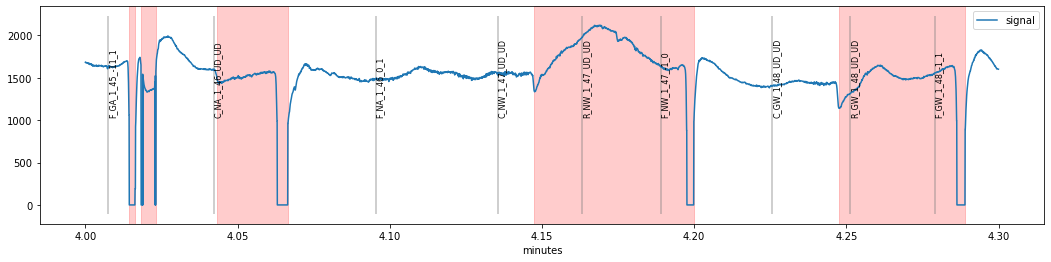

In [25]:
d=pp.PupilData.from_file("../data/test.pd")
plt.figure(figsize=(18,4))
d.blinks_detect().plot((4,4.3), units="min")

We see that a period of seemingly valid pupil-data (around times 4.05 and 4.15 min) was marked as blink because of a sudden downward change in the pupil signal which might resemble the onset of a blink (a likely source of these artifacts are sudden eye-movements but we would need eyetracking-data to corrobate this hypothesis). 

his problem can be fixed by setting a stricter value for the velocity-profile based onset detection `vel_onset` or requiring a more prolonged onset-transient by increasing `min_onset_len`:

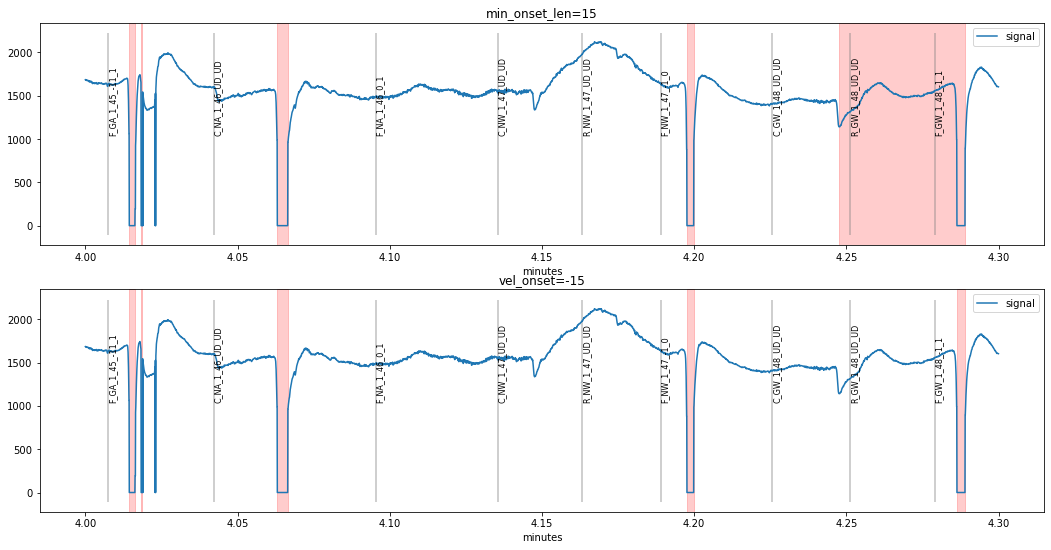

In [48]:
plt.figure(figsize=(18,9))
d1=d.blinks_detect(min_onset_len=15)
d2=d.blinks_detect(vel_onset=-15)

plt.subplot(2,1,1)
d1.plot((4,4.3), units="min")
plt.title("min_onset_len=15")
plt.subplot(2,1,2)
d2.plot((4,4.3), units="min")
plt.title("vel_onset=-15");

The second method changing `vel_onset` seems to have worked better, as the last "false-positive" around time 4.25 is still present when increasing `min_onset_len`. However, we introduced a new problem, as the ultra-short blink at time 4.024 went undetected. As a consequence, we can decrease the minimum blink-duration required `min_duration`.

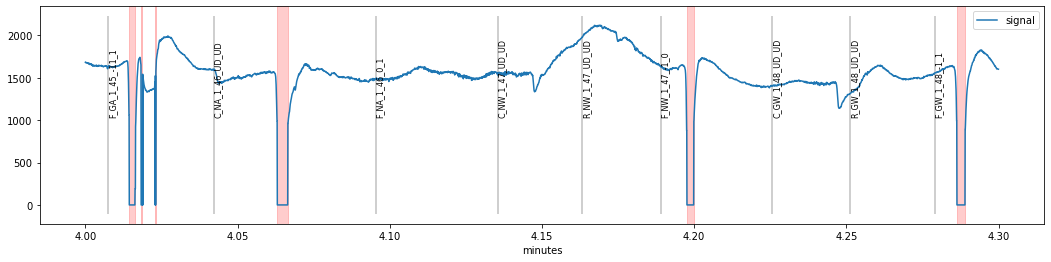

In [54]:
plt.figure(figsize=(18,4))
d.blinks_detect(vel_onset=-15, min_duration=5).plot((4,4.3), units="min")

## Merging blinks

Some subjects blink in quick succession so that the eye almost immediately starts closing again once it opens from the previous blink. In that case, it is very difficult to define the onset and offset of such blink sequences and interpolation is even more difficult. 

We reuse the first example above, which is from a dataset recorded in our lab. We see a couple of "normal" blinks, as well as some fast sequences of sequential blinks (e.g., between seconds 131 and 134).

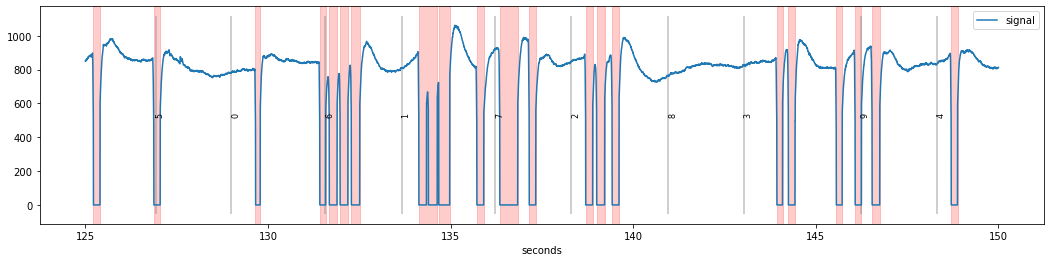

In [58]:
d=pp.PupilData.from_file("../data/example_shortblinks.pd")
plt.figure(figsize=(18,4))
d.blinks_detect().plot()

If we would attempt a normal interpolation of these blinks separately, the interpolation would fail because the signal "neighbouring" the blink is contaminated by new blinks. Therefore, such sequences should be merged before interpolation using function `blinks_merge()`. We can specifiy how far apart two blinks need to be to be treated as separate blinks by setting the `distance=` argument (in units of ms).

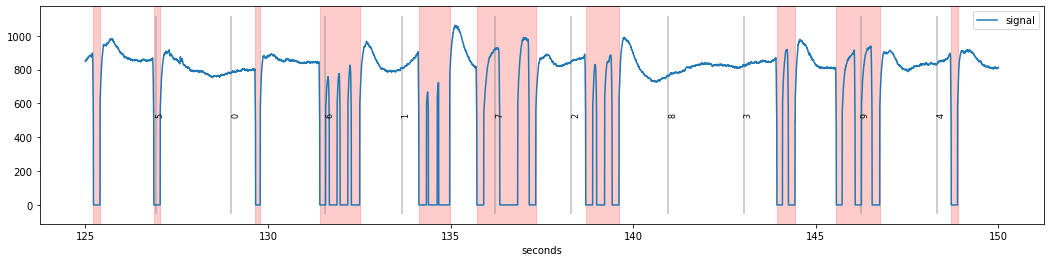

In [93]:
plt.figure(figsize=(18,4))
d=d.blinks_detect().blinks_merge(distance=130)
d.plot()

Here, we require 50 ms of clean signal between two blinks. As a consequence, we see that the rapid blink sequences have been merged together and can safely be interpolated.

## Interpolating blinks

The final step in the treatment of blinks is to actually replace the contaminated parts of the signal, a procedure known as *interpolation*.

In `pypillometry`, there are currently two implementation functions available, `blinks_interpolate()` and `blinks_interp_mahot()`. The difference between the two functions is which datapoints are used for interpolation. While `blinks_interpolate()` uses all available datapoints, `blinks_interp_mahot()` uses only four points that are determined by a heuristic following a [suggestion by Sebastiaan Mahot (2013)](https://figshare.com/articles/A_simple_way_to_reconstruct_pupil_size_during_eye_blinks/688001).

Both approaches can be tweaked to give good results but `blinks_interp_mahot()` seems to work better in general.

We will now use this approach and plot the interpolated signal on top of the original one:

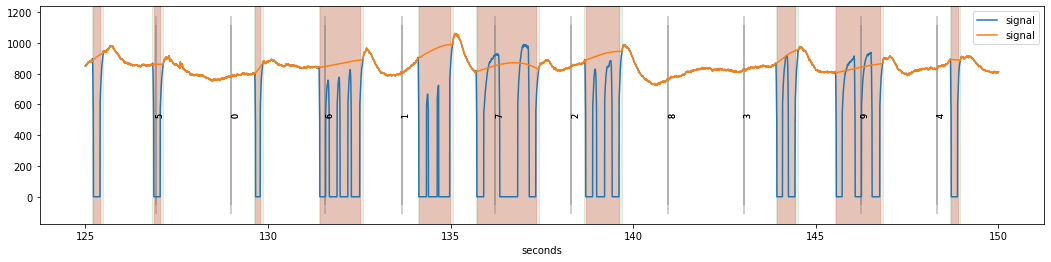

In [94]:
dinterp=d.blinks_interp_mahot()

plt.figure(figsize=(18,4))
d.plot()
dinterp.plot(highlight_blinks=False)

While the resulting signal looks somewhat ok'ish, there are some worrying discontinuities in the reconstructed signal especially at the end of some blink periods, e.g., the one around 133 seconds. The reason for this is that the opening of the pupil was somewhat slow for this subject and therefore the upward-going transient at the end of the blinks is not yet fully recovered to the pre-blink baseline levels. 

The solution for this dataset is to set the `margin`-parameter of the procedure to a larger value. Here, we set the `margin` parameter to (50,100) ms (50 ms for the onset and 100 ms for the offset of the transient). Plotting the two interpolations on top of each other, the one with appropriate settings of the `margin` parameter has fewer discontinuities.

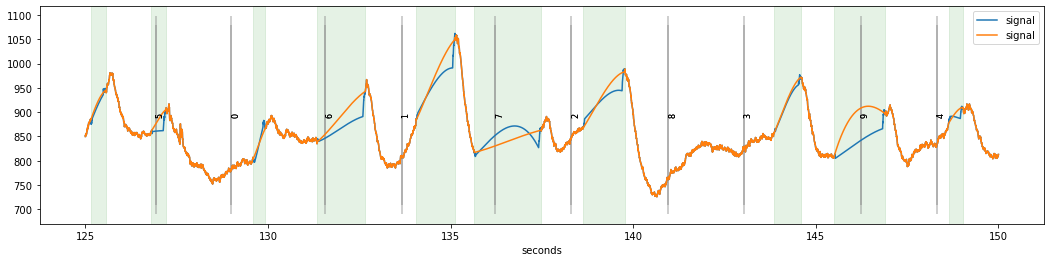

In [96]:
dinterp2=d.blinks_interp_mahot(margin=(50,100))#, plot=True, plot_figsize=(25,15), plot_dim=(5,5));

plt.figure(figsize=(18,4))
dinterp.plot(highlight_blinks=False, highlight_interpolated=False)
dinterp2.plot(highlight_blinks=False)

The procedure has more parameters that can be tweaked to make interpolation even better. Please refer to [Mahot (2013)](https://figshare.com/articles/A_simple_way_to_reconstruct_pupil_size_during_eye_blinks/688001) for a short and readable summary of what these parameters do. 

Finally, the `blinks_interp_mahot()` function supports an argument `plot=True` that visualizes the interpolation procedure and can help to detect errors and set the parameters appropriately:

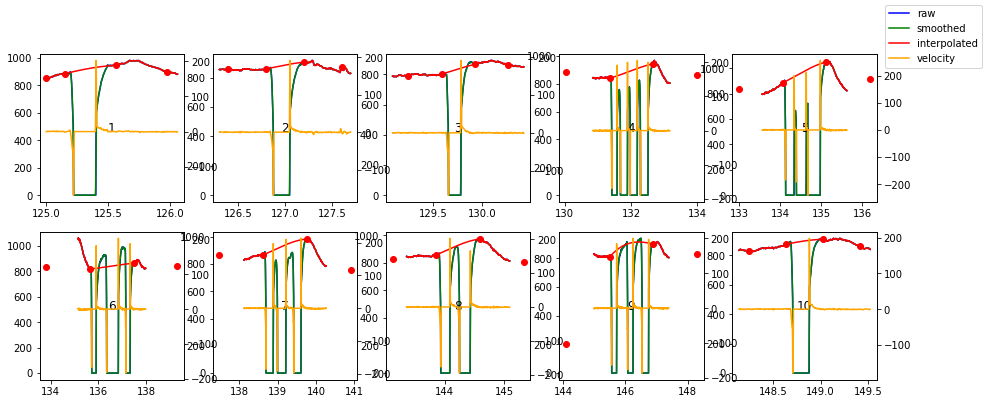

In [100]:
d.blinks_interp_mahot(margin=(50,100), plot=True, plot_figsize=(15,6), plot_dim=(2,5));